# Explaining brain stroke model with LIME

### 1. Calculate the predictions for some selected observations
For this task I will prepare the data in the same way as in the first homework.

In [15]:
import pandas as pd
from sklearn.preprocessing import minmax_scale, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df = pd.read_csv("brain_stroke.csv")

enc = OrdinalEncoder()
df[["Residence_type", "ever_married", "gender"]] = enc.fit_transform(df[["Residence_type", "ever_married", "gender"]])
df = pd.get_dummies(df, columns=["work_type"])
df = df.drop(columns=["smoking_status"])
df[['age','avg_glucose_level','bmi']] = minmax_scale(df[['age','avg_glucose_level','bmi']])

X = df.drop("stroke", axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=5)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

As in previous homework I will train RandomForestClassifier.

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=4, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

I selected two random samples with setted random state that the results will be repeatable. One of the people has a positive prediction and the other a negative one, people differ mainly in age and type of employment.

In [33]:
samples = X_test.reset_index(drop=True).sample(2, random_state=0)
print("Random forest predicted labels:", rfc.predict(samples))
print("Random forest predicted probability:", rfc.predict_proba(samples))
print(samples)

Random forest predicted labels: [1 0]
Random forest predicted probability: [[0.31024794 0.68975206]
 [0.76785253 0.23214747]]
      gender       age  hypertension  heart_disease  ever_married  \
1068     0.0  0.951172             0              0           1.0   
124      0.0  0.572754             0              0           1.0   

      Residence_type  avg_glucose_level       bmi  work_type_Govt_job  \
1068             0.0           0.250900  0.481375                   0   
124              0.0           0.261102  0.730659                   1   

      work_type_Private  work_type_Self-employed  work_type_children  
1068                  0                        1                   0  
124                   0                        0                   0  


### 2. Decomposition of selected predictions with `LIME`

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



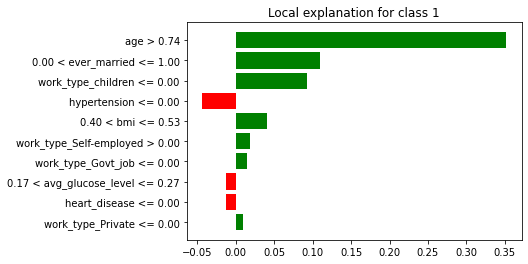

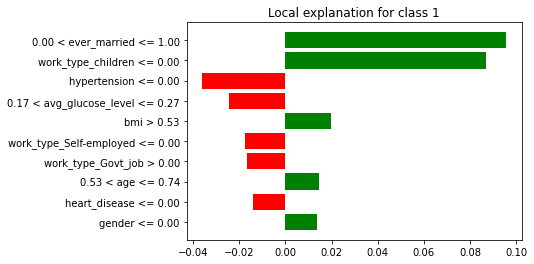

In [34]:
import dalex

rfc_exp = dalex.Explainer(rfc, X_test, y_test, verbose=False)
rfc_exp.predict(samples)
rfc_exp.predict_surrogate(samples.iloc[[0]]).plot()
rfc_exp.predict_surrogate(samples.iloc[[1]]).plot()

### 3. Compare LIME for various observations in the dataset. How stable are these explanations?

Random forest predicted probability: [[0.62519358 0.37480642]]


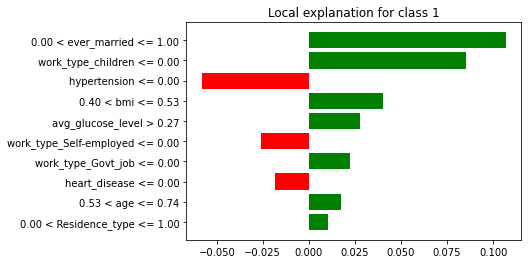

In [35]:
sample = X_test.iloc[[0]]
print("Random forest predicted probability:", rfc.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()

Random forest predicted probability: [[0.25445059 0.74554941]]


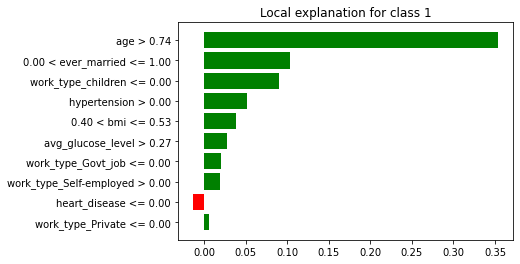

In [36]:
sample = X_test.iloc[[1]]
print("Random forest predicted probability:", rfc.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()

Random forest predicted probability: [[0.72197641 0.27802359]]


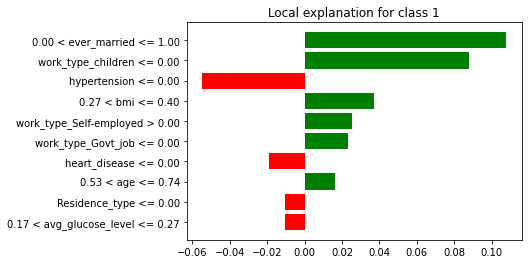

In [37]:
sample = X_test.iloc[[2]]
print("Random forest predicted probability:", rfc.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()

Random forest predicted probability: [[0.82042794 0.17957206]]


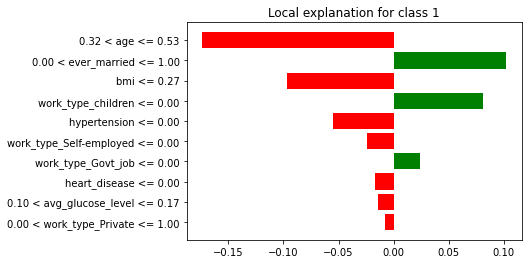

In [38]:
sample = X_test.iloc[[3]]
print("Random forest predicted probability:", rfc.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()

Random forest predicted probability: [[0.30168599 0.69831401]]


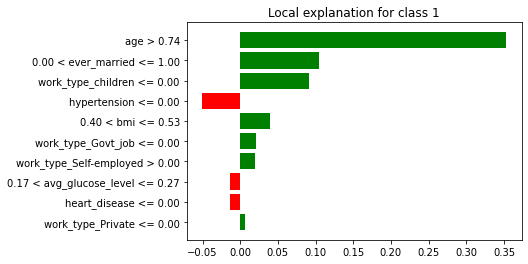

In [39]:
sample = X_test.iloc[[4]]
print("Random forest predicted probability:", rfc.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()

For each of the negative predictions, the value of not being married seems to be an important property. However, age seems to be the most important factor for positive predictions. Summing up, the explanations seem to be stable for a given type of prediction.

### 4. Compare LIME with the explanations obtained using SHAP. What are the main differences between them?

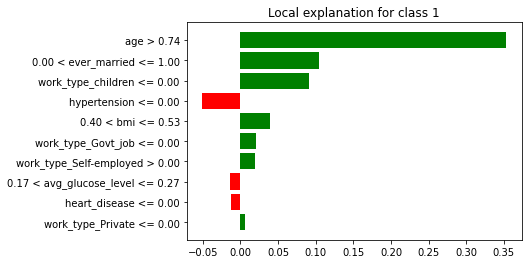

In [40]:
rfc_exp.predict_surrogate(samples.iloc[[0]], random_state=0).plot()
rfc_exp.predict_parts(samples.iloc[[0]], 'shap', N=500, random_state=0).plot()

Explanation with shap and lime give similar results and intuition about the importance of features. Explaining with LIME, however, notes the importance of the hypertension property, which for sharp does not appear to be essential. An additional advantage of the lime method is the recipe for a ready-made, lightweight model that gives good predictions for people with features similar to the tested person.

### 5. Compare LIME between at least two different models. Are there any systematic differences across many observations?

In [31]:
from sklearn.linear_model import LogisticRegression
import time
lr = LogisticRegression()  # Creating model with default parameters
lr.fit(X_train, y_train)  # Fitting model
lr_exp = dalex.Explainer(lr, X_test, y_test, verbose=False)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



     gender       age  hypertension  heart_disease  ever_married  \
468     0.0  0.658203             0              0           1.0   

     Residence_type  avg_glucose_level       bmi  work_type_Govt_job  \
468             1.0           0.341797  0.527221                   0   

     work_type_Private  work_type_Self-employed  work_type_children  
468                  1                        0                   0  
Random forest predicted probability: [[0.62519358 0.37480642]]
Linear regression predicted probability: [[0.56341589 0.43658411]]


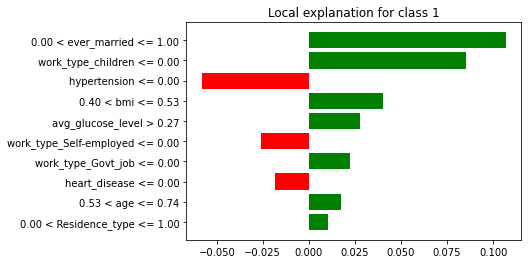

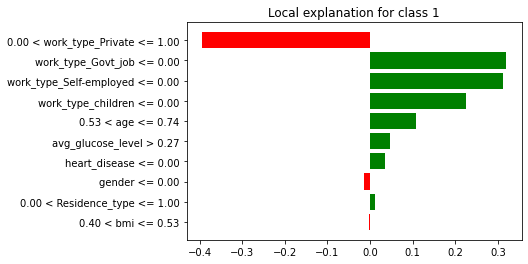

In [28]:
sample = X_test.iloc[[0]]
print(sample)
print("Random forest predicted probability:", rfc.predict_proba(sample))
print("Linear regression predicted probability:", lr.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()
lr_exp.predict_surrogate(sample, random_state=0).plot()

     gender       age  hypertension  heart_disease  ever_married  \
814     1.0  0.987793             1              0           1.0   

     Residence_type  avg_glucose_level       bmi  work_type_Govt_job  \
814             1.0           0.812806  0.504298                   0   

     work_type_Private  work_type_Self-employed  work_type_children  
814                  0                        1                   0  
Random forest predicted probability: [[0.25445059 0.74554941]]
Linear regression predicted probability: [[0.08348803 0.91651197]]


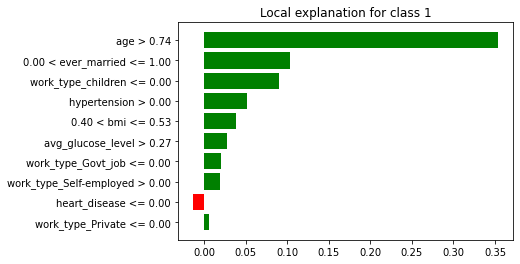

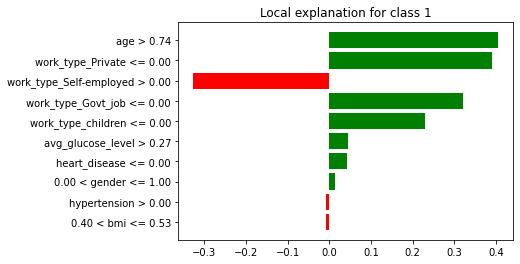

In [29]:
sample = X_test.iloc[[1]]
print(sample)
print("Random forest predicted probability:", rfc.predict_proba(sample))
print("Linear regression predicted probability:", lr.predict_proba(sample))
rfc_exp.predict_surrogate(sample, random_state=0).plot()
lr_exp.predict_surrogate(sample, random_state=0).plot()

The explanations of the model in the case of linear regression and random trees differ significantly. First of all, for the random trees model, a very important feature of the explanation is marital status, while the explanation for linear regression ignores this feature. In addition, self-employment in the random forest model has a positive effect on the predictions, while in the linear regression model it has a negative effect. However, both models agree on the importance and influence of the age range, the older the person, the greater the likelihood of a stroke.